# RDS HW2 solution

Install the Data Synthesizer library.

In [102]:
!pip install DataSynthesizer

In [103]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed, display_bayesian_network

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [104]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']
    
    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [105]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']
    
    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [106]:
def generate_data_CD(input_data_file, output_data_size, description_file, verbose, epsilon=0.5,  k=1, seed=None):
    seed = seed or randint(0, 2**30)
    
    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    if verbose:
      display_bayesian_network(describer.bayesian_network)
    describer.save_dataset_description_to_file(description_file)
    
    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, verbose, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], verbose, epsilon=epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size,  verbose, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'],  verbose, epsilon=epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [107]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client. 
# Please follow the steps as instructed when you run the following commands. 

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [109]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'    
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'    
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas}) 
downloaded.GetContentFile(real_data_file)  
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake}) 
downloaded.GetContentFile(fake_data_file)  
df_fake = pd.read_csv(fake_data_file)

In [110]:
output_data_size = 10000
epsilon = 0.1

seed = 27  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json', 
                     'B': './descrption_B.json', 
                     'C': './descrption_C.json', 
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
#displaying Bayesian Network to understand important relationships between our variables
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, verbose= True)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon, verbose=True)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
#displaying Bayesian Network to understand important relationships between our variables
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon, verbose=True)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon, verbose=True)

#clear_output()

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute race
Adding attribute sex
Adding attribute age
========================== BN constructed ==========================
Constructed Bayesian network:
    race has parents ['score'].
    sex  has parents ['race'].
    age  has parents ['race'].
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
Constructed Bayesian network:
    score has parents ['sex'].
    age   has parents ['score', 'sex'].
    race  has parents ['age', 'sex'].
================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_1
Adding attribute child_1
Adding attribute child_2
Adding attribute parent_2
========================== BN constructed ==========================
Constructed Bayesian network:
    child_1  has parents ['paren

## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [111]:
def compare_agg_metrics(df_list, col, metric_list = ['min','median','mean','max'],\
                        df_str_list = ['df_real', 'df_real_A', 'df_real_B', 'df_real_C', 'df_real_D']):
  """
  A function that calculates the aggregate metrics for various dataframes and outputs the aggregates in a singular dataframe
  Input args: 
    df_list -- list of dataframes to calculate aggregate metrics on
    col -- the specific column we will be calculating various aggregate metrics on
    metric_list -- a list containing the aggregates we will be calculating (min, median, mean, max) per question guidelines
  Returns: Results_df -- a dataframe with columns corresponding to individual dataframes and columns we have aggregated and rows corresponding to the aggregate metric
  """
  results = pd.DataFrame()
  for i in range(len(df_list)):
      temp_df = df_list[i].agg(metric_list)[col[0]].round(3)
      temp_df.name = df_str_list[i]+'_'+col[0]
      results = results.join(temp_df, how='outer')
  return(results)

df_list = [df_real, df_real_A, df_real_B, df_real_C, df_real_D] 
age_comparison = compare_agg_metrics(df_list, ['age'])
score_comparison = compare_agg_metrics(df_list, ['score'])



In [112]:
age_comparison

,df_real_age,df_real_A_age,df_real_B_age,df_real_C_age,df_real_D_age
min,18.000,0.000,18.000,18.000,18.00
median,32.000,50.000,32.000,34.000,41.00
mean,35.143,50.162,36.103,37.479,47.21
max,96.000,100.000,80.000,96.000,96.00


In [113]:
score_comparison

,df_real_score,df_real_A_score,df_real_B_score,df_real_C_score,df_real_D_score
min,-1.000,-1.0,1.000,-1.000,-1.000
median,4.000,5.0,4.000,4.000,4.000
mean,4.371,4.9,4.393,4.336,4.433
max,10.000,10.0,10.000,10.000,10.000


### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

Text(0.5, 1.0, 'independent attribute mode')

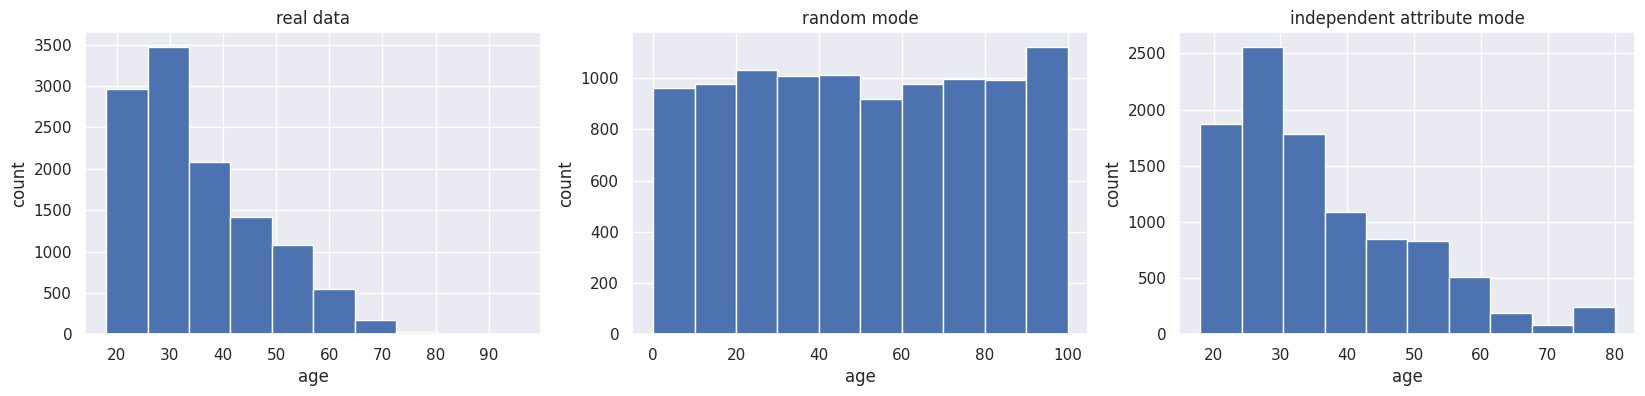

In [114]:
#4.2 Plotting distributions of real vs synthetically generated data for the column age
fig, axes = plt.subplots(1,3, figsize = (20,4), dpi=(100))
axes[0].hist(df_real['age'])
axes[1].hist(df_real_A['age'])
axes[2].hist(df_real_B['age'])
axes[0].set_xlabel('age')
axes[1].set_xlabel('age')
axes[2].set_xlabel('age')
axes[0].set_ylabel('count')
axes[1].set_ylabel('count')
axes[2].set_ylabel('count')
axes[0].set_title('real data')
axes[1].set_title('random mode')
axes[2].set_title('independent attribute mode')

Text(0.5, 1.0, 'independent attribute mode')

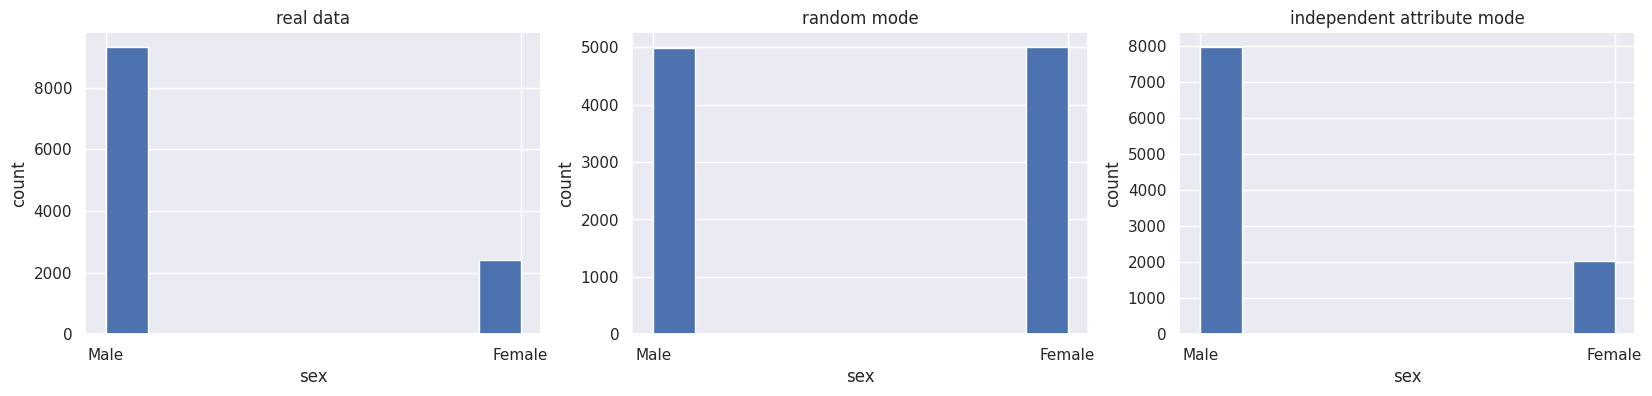

In [115]:
#4.2 Plotting distributions of real vs synthetically generated data for the column race
fig, axes = plt.subplots(1,3, figsize = (20,4), dpi=(100))
axes[0].hist(df_real['sex'])
axes[1].hist(df_real_A['sex'])
axes[2].hist(df_real_B['sex'])
axes[0].set_xlabel('sex')
axes[1].set_xlabel('sex')
axes[2].set_xlabel('sex')
axes[0].set_ylabel('count')
axes[1].set_ylabel('count')
axes[2].set_ylabel('count')
axes[0].set_title('real data')
axes[1].set_title('random mode')
axes[2].set_title('independent attribute mode')

In [116]:
#cell used to examine KL-divergence on race categorical variable
"""
fig, axes = plt.subplots(1,3, figsize = (20,4), dpi=(100))
axes[0].hist(df_real['race'])
axes[1].hist(df_real_A['race'])
axes[2].hist(df_real_B['race'])
axes[0].set_xlabel('race')
axes[1].set_xlabel('race')
axes[2].set_xlabel('race')
axes[0].set_ylabel('count')
axes[1].set_ylabel('count')
axes[2].set_ylabel('count')
axes[0].set_title('real data')
axes[1].set_title('random mode')
axes[2].set_title('independent attribute mode')
"""
clear_output()

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [117]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])

In [118]:
ks_test(df_real_A, df_real_B, 'age')

Ks_2sampResult(statistic=0.3465, pvalue=0.0)

#### KL-divergence for categorical attributes

In [119]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

kl_test(df_real_A, df_real_B, 'sex')
#used to validate KL-divergence on race
#kl_test(df_real_A, df_real_B, 'race')

0.19131645392363766

### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

In [120]:
# Use pairwise_attributes_mutual_information function. 
# For function parameters, refer to https://github.com/DataResponsibly/DataSynthesizer/blob/master/DataSynthesizer/lib/utils.py#L31
# Your code here
df_fake.head()
df_fake_C.head()


true_pw_mi = pairwise_attributes_mutual_information(df_fake)
#B_pw_mi = pairwise_attributes_mutual_information(df_fake_B)
C_pw_mi = pairwise_attributes_mutual_information(df_fake_C)
D_pw_mi = pairwise_attributes_mutual_information(df_fake_D)

In [122]:

## using lab 7/8 code

from DataSynthesizer.ModelInspector import ModelInspector
attribute_description_C = read_json_file(description_files['C'])['attribute_description']
attribute_description_D = read_json_file(description_files['D'])['attribute_description']

# ModelInspector(df_fake,
#                df_fake_C,
#                attribute_description_C).mutual_information_heatmap()

#clear_output

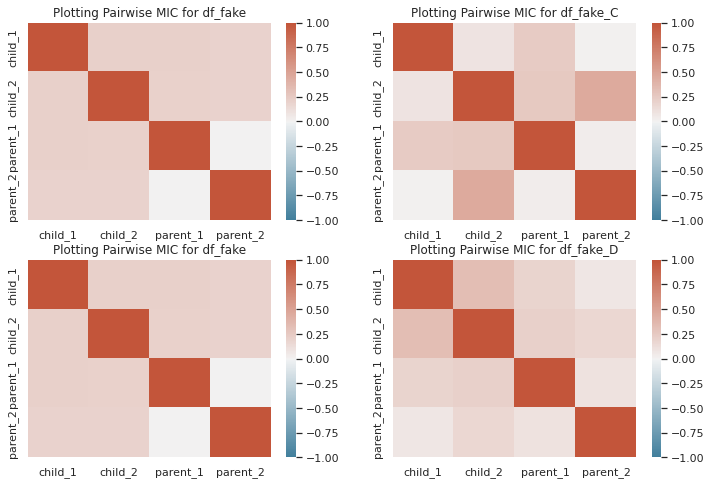

In [123]:
fig, axes = plt.subplots(2,2, figsize=(12,8))
i =0 

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

coef_list = [true_pw_mi,C_pw_mi, true_pw_mi, D_pw_mi]
title_list = ['df_fake', 'df_fake_C', 'df_fake', 'df_fake_D']
for row in range(2):
    for col in range(2):   
        test = axes[row, col]
        sns.set_theme(style="darkgrid")
        sns.heatmap(ax=test, data=coef_list[i], cmap = cmap, vmin = -1, vmax=1)

        test.title.set_text('Plotting Pairwise MIC for ' + title_list[i])
        i +=1


## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

In [124]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html

def understand_variability():
  """
  function that generates ten synthetic datasets COMPAS, calculates the min, mean, median, max of the age column and outputs them in a dictionary
  each key in that dictionary corresponds to the method used to synthetically generate the dataset
  the value of the key is a dictionary that has our four metrics of interest. The values of this dictionary are the recorded metrics
  """
  #create results dict
  results_dict = {'A':{'min':[],
                       'mean':[],
                       'median':[],
                       'max':[]
                       }, 
                  'B':{'min':[],
                       'mean':[],
                       'median':[],
                       'max':[]
                       }, 
                  'C':{'min':[],
                       'mean':[],
                       'median':[],
                       'max':[]
                      }
                  }

  metric_list = ['min','mean','median','max']
  #keyboard smashing to generate random seeds after using three numbers i personally like  

  seed_list = [27,65,26, 23412, 34012, 234789, 1923845, 1923479, 109823, 872640]
  for seed in seed_list:

  #generate three temp datasets
    temp_A = generate_data_A(real_data_file, output_data_size, seed=seed)
    temp_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
    temp_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, seed=seed, verbose=False)
    clear_output
    df_str_list = ['df_A', 'df_B', 'df_C']
  #make a list of the above datasets
    df_list = [temp_A,temp_B,temp_C]
    age_comparison = compare_agg_metrics(df_list, ['age'], df_str_list=df_str_list)
    clear_output()
    #specifiying a key list to guarantee an order in below for loop when indexing 
    key_list = ['A','B','C']
    for i in range(len(key_list)):
      for j in range(len(metric_list)):
        results_dict[key_list[i]][metric_list[j]].append(age_comparison.to_numpy()[j,i]) 

  return(results_dict)

In [125]:
results = understand_variability()

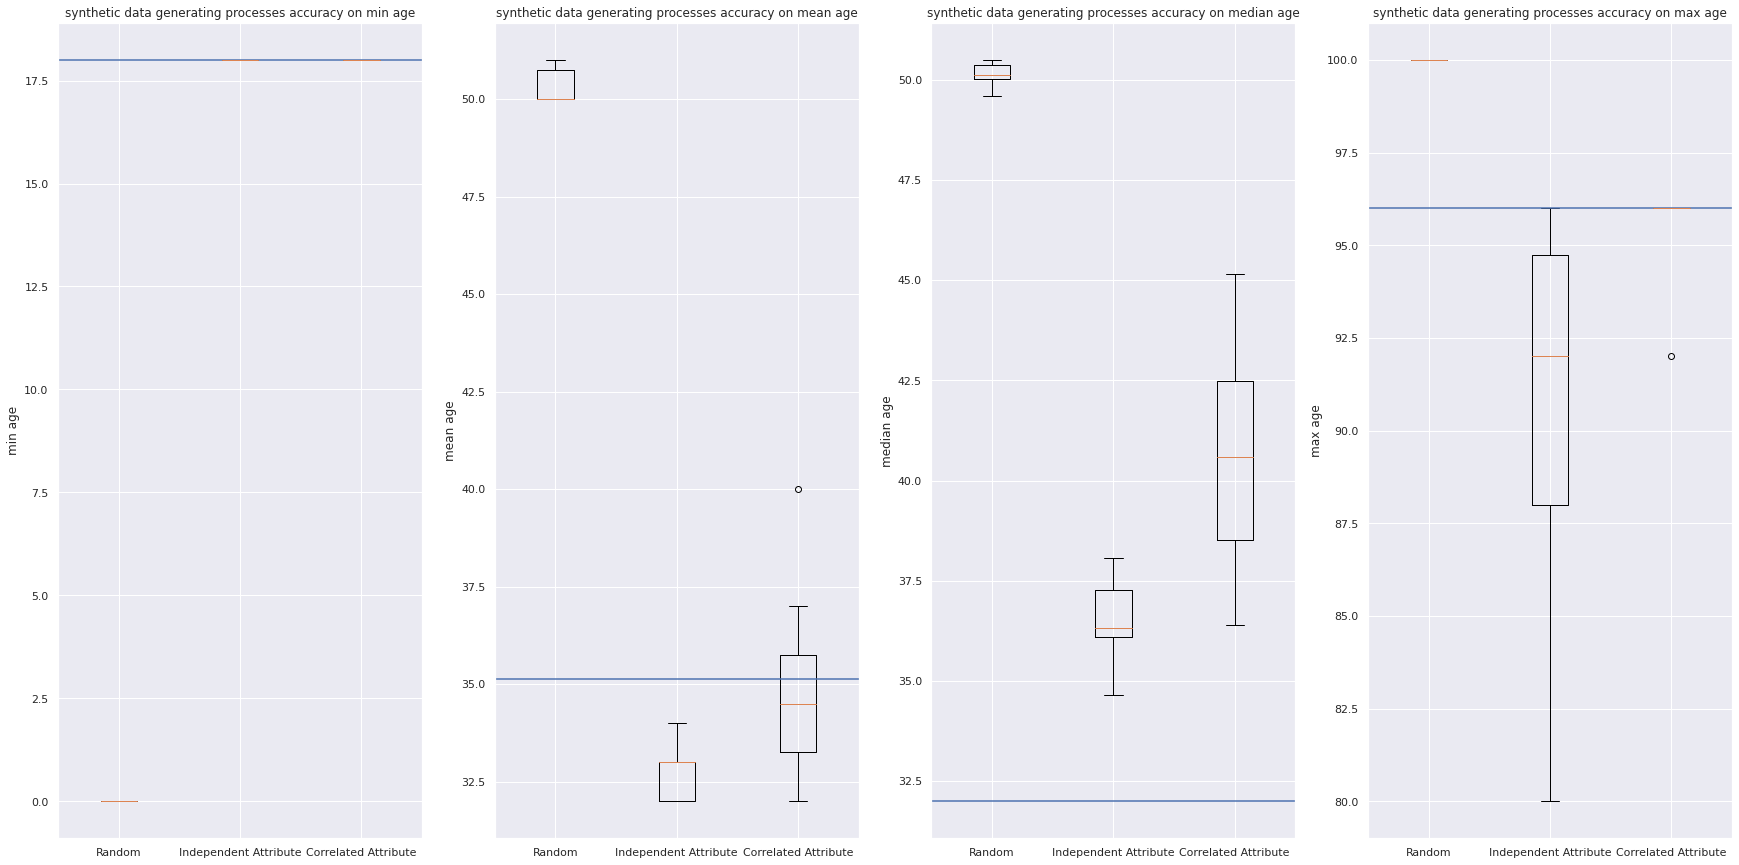

In [126]:
#plotting  the min, mean, median, and max value of age across 10 different synthetically generated datasets across various synthetic
#dataset generation methods
fig, axs = plt.subplots(1,4, figsize=(30,15))
metric_list = ['min', 'mean', 'median', 'max']
for i in range(len(metric_list)):
  metric = metric_list[i]
  ax = axs[i] 
  ax.boxplot([results['A'][metric], results['B'][metric],results['C'][metric]], labels=['Random', 'Independent Attribute', 'Correlated Attribute'])
  ax.set_title('synthetic data generating processes accuracy on ' + metric_list[i] + ' age')
  ax.set_ylabel(metric + ' age')
  ax.axhline(y=age_comparison['df_real_age'][metric])

## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

In [127]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html

def understand_variability2():
  """
  function that generates ten synthetic COMPAS datasets, and calculates the KL-divergence for the race column 
  across varying levels of epsilon 
  """
  #create results dict
  results_dict = {'B':{.01:[],
                       .02:[],
                       .03:[],
                       .04:[], 
                       .05:[],
                       .06:[],
                       .07:[],
                       .08:[],
                       .09:[],
                       .1:[]
                       },
                  'C':{.01:[],
                       .02:[],
                       .03:[],
                       .04:[], 
                       .05:[],
                       .06:[],
                       .07:[],
                       .08:[],
                       .09:[],
                       .1:[]
                       }, 
                  'D':{.01:[],
                       .02:[],
                       .03:[],
                       .04:[], 
                       .05:[],
                       .06:[],
                       .07:[],
                       .08:[],
                       .09:[],
                       .1:[]
                       }
                  }
  key_list = ['B','C','D']

  #keyboard smashing to generate random seeds after using three numbers i personally like  
  epsilon_list = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]
  seed_list = [27,65,26, 23412, 34012, 234789, 1923845, 1923479, 109823, 872640]
  for i in range(len(epsilon_list)):
    for j in range(len(seed_list)):
      #generate three temp datasets
      temp_B = generate_data_B(real_data_file, output_data_size, epsilon= epsilon_list[i], seed=seed_list[j])
      temp_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)
      temp_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)
      clear_output()
  #make a list of the above datasets
      df_list = [temp_B, temp_C, temp_D]
    #specifiying a key list to guarantee an order in below for loop when indexing 
      for v in range(len(key_list)):
          results_dict[key_list[v]][epsilon_list[i]].append(kl_test(df_real,df_list[v], 'race'))
  return(results_dict)

In [128]:
results_dict2 = understand_variability2()

(0.0, 1.2)

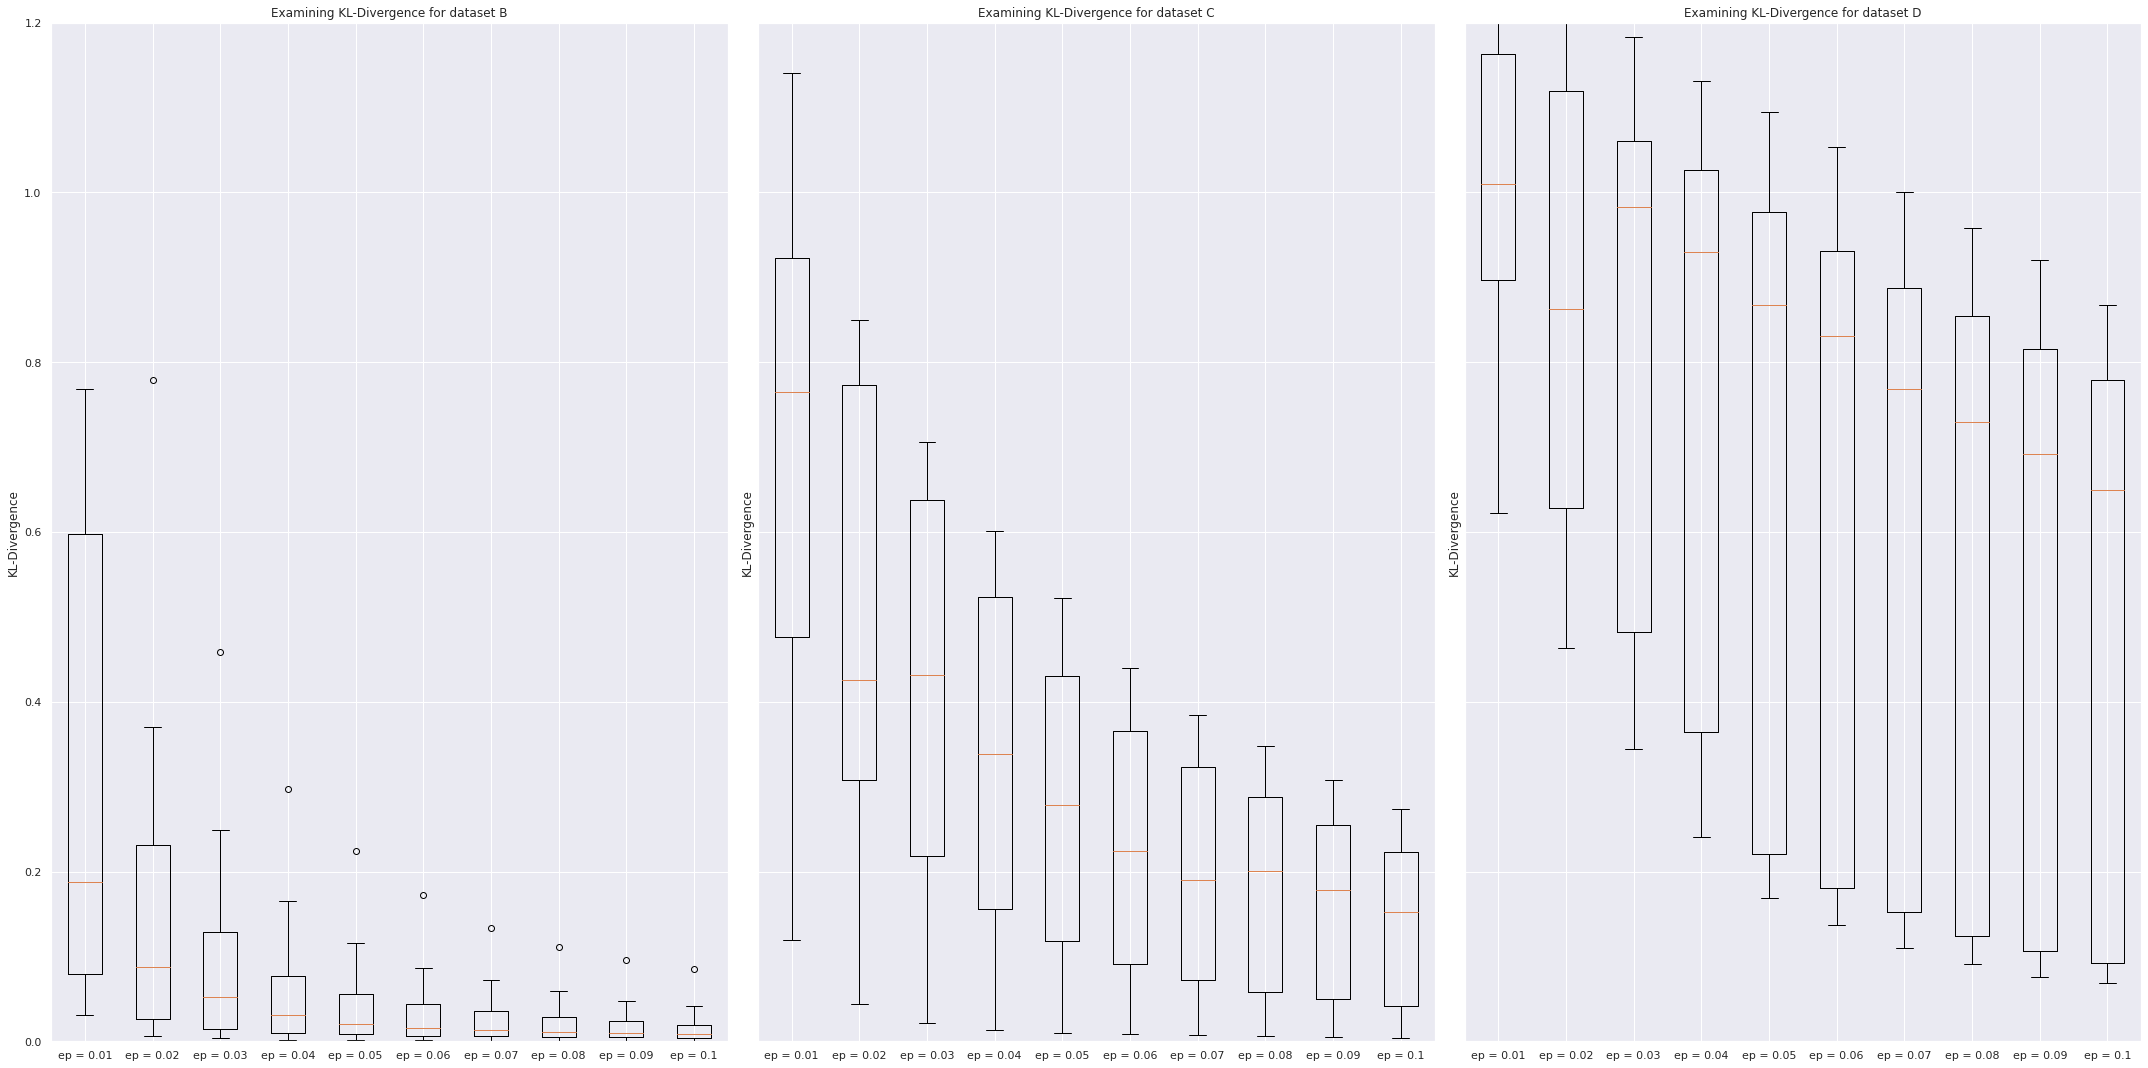

In [157]:
#plotting kl divergence across various synthetic data generating methods for the race column
fig, axs = plt.subplots(1,3, figsize=(30,15), sharey=True)
e = [ep for ep in results_dict2['B'].keys()]

key_list = ['B','C','D']

for i in range(3):
  k = key_list[i]
  d = results_dict2[k]
  label_list = ['ep = ' + str(ep) for ep in e]
  ax = axs[i] 
  ax.boxplot([d[e[0]], d[e[1]], d[e[2]],d[e[3]], d[e[4]], d[e[5]], d[e[6]], d[e[7]], d[e[8]], d[e[9]]],
             labels=label_list)
  ax.set_title('Examining KL-Divergence for dataset ' + k)
  ax.set_ylabel('KL-Divergence')
plt.tight_layout()
#set ylim to be the same for all plots
plt.ylim((0,1.2))


In [27]:
import numpy as np
def understand_variability3():
  """
  solves 4.3, this function does a lot
  """
  #create results dict
  results_dict1 = {'B_compas':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       },
                  'C_compas':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }, 
                  'D_compas':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }
                  }
  results_dict2 = {'B_fake':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       },
                  'C_fake':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }, 
                  'D_fake':{.0001:[],
                       .001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }
                  }
  
  key_list1 = ['B_compas','C_compas','D_compas']
  key_list2 = ['B_fake', 'C_fake', 'D_fake']
  
  compas_mic = pairwise_attributes_mutual_information(df_real)
  fake_mic = pairwise_attributes_mutual_information(df_fake)

  #keyboard smashing to generate random seeds after using three numbers i personally like  
  epsilon_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
  seed_list = [27,65,26, 23412, 34012, 234789, 1923845, 1923479, 109823, 872640]
  for i in range(len(epsilon_list)):
    for j in range(len(seed_list)):
      #generate three temp datasets for both compas and fake dataset

      temp_B1 = generate_data_B(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j])
      temp_C1 = generate_data_C(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)
      temp_D1 = generate_data_D(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)

      temp_B2 = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j])
      temp_C2 = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)
      temp_D2 = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)

      clear_output()
  #make a list of the above datasets
      df_list1 = [temp_B1, temp_C1, temp_D1]
      df_list2 = [temp_B2, temp_C2, temp_D2]

    #specifiying a key list to guarantee an order in below for loop when indexing 
      for v in range(len(key_list1)):
          pairwise_mic_1 = pairwise_attributes_mutual_information(df_list1[v])
          pairwise_mic_2 = pairwise_attributes_mutual_information(df_list2[v])

          delta_matrix1 = abs(pairwise_mic_1 - compas_mic)
          delta_matrix2 = abs(pairwise_mic_2-fake_mic)
          
          cumulative_mic_1 = np.tril(delta_matrix1).sum()-np.trace(delta_matrix1) #trace is all 0s, formula for lower diagonal
          cumulative_mic_2 = np.tril(delta_matrix2).sum()-np.trace(delta_matrix2) #trace is all 0s, formula for lower diagonal

          results_dict1[key_list1[v]][epsilon_list[i]].append(cumulative_mic_1)
          results_dict2[key_list2[v]][epsilon_list[i]].append(cumulative_mic_2)
  return([results_dict1,results_dict2])

In [28]:
results_4c_pt2 = understand_variability3()

(0.0, 2.0)

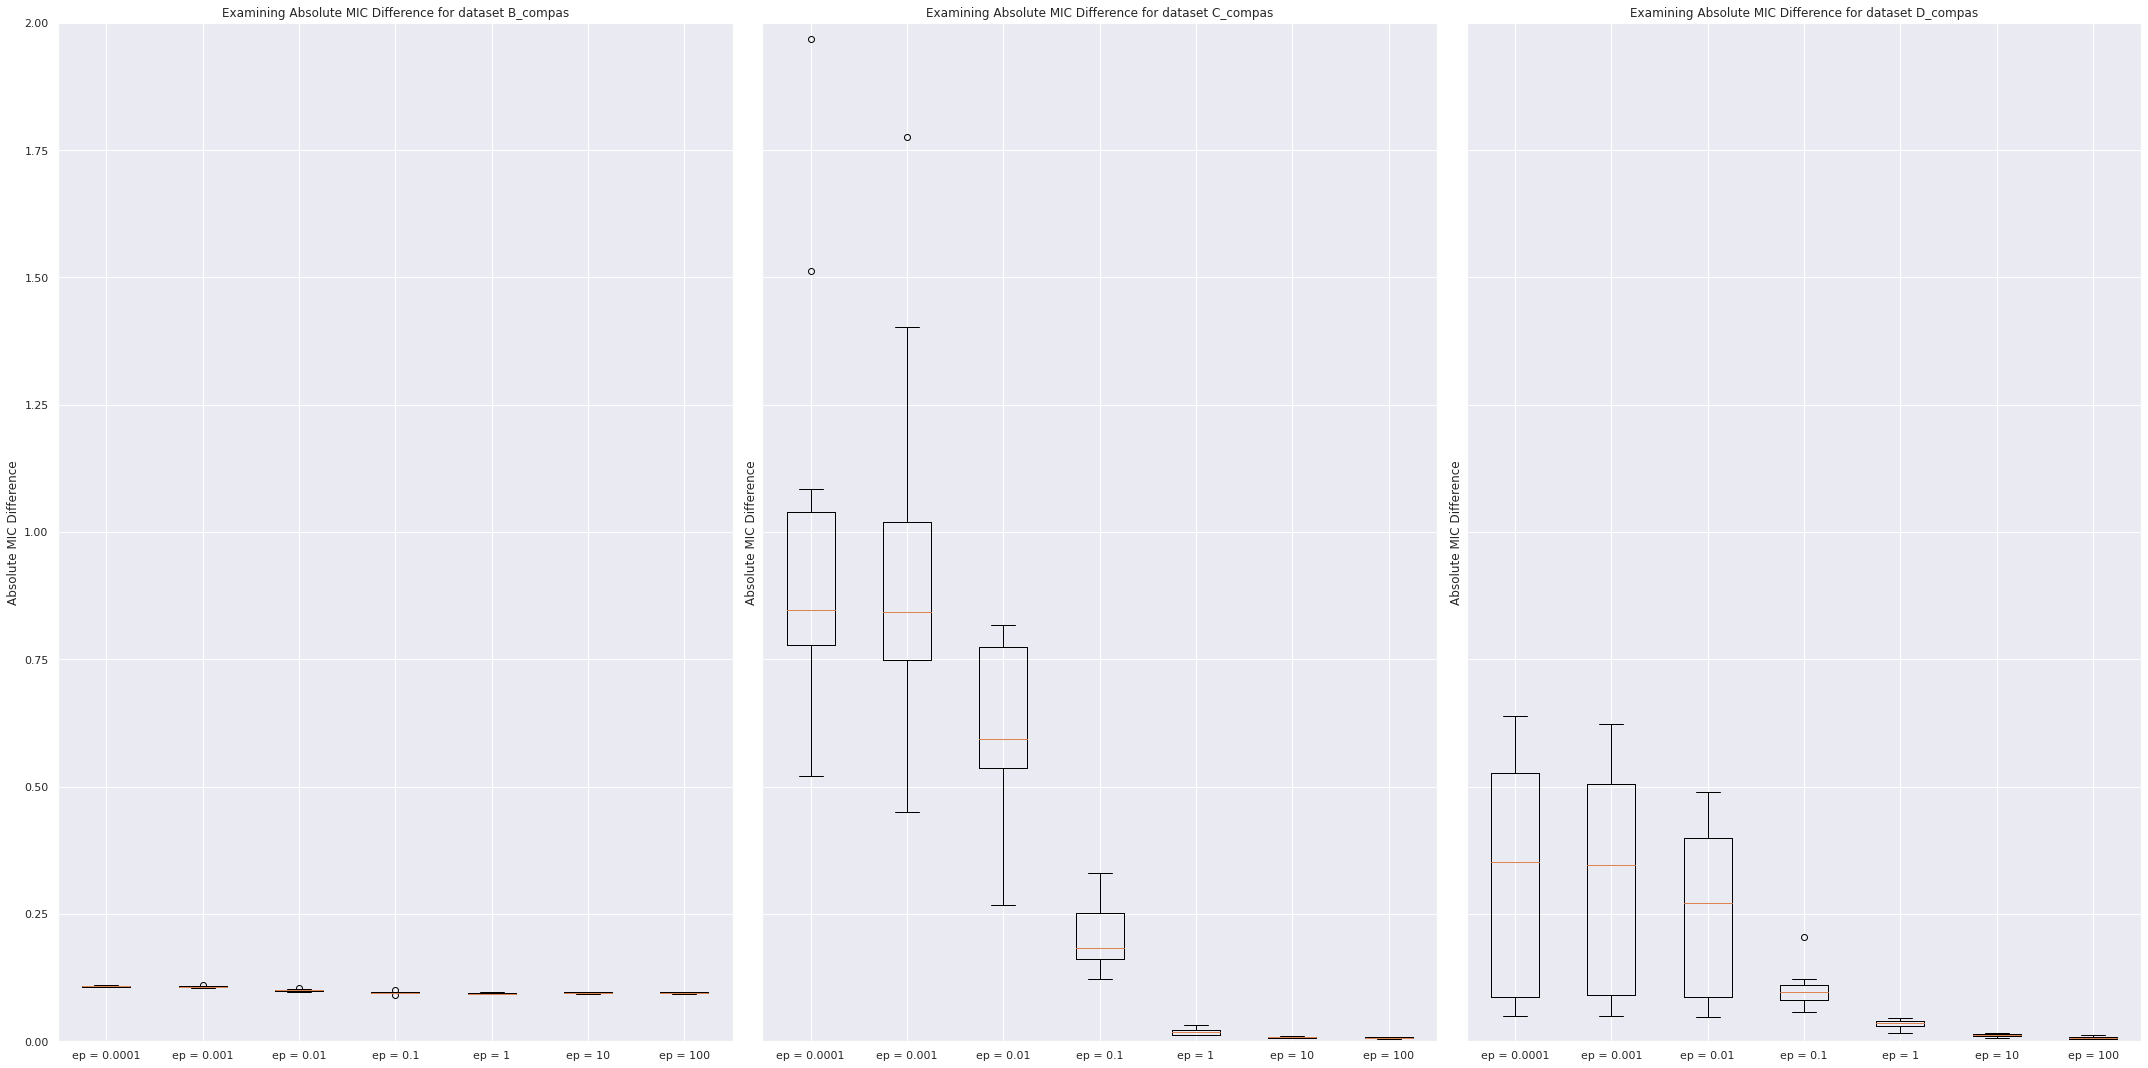

In [92]:
#plotting the MIC  difference for different synthetic data generating methods on Compas data
fig, axs = plt.subplots(1,3, figsize=(30,15),sharey=True)
e = [ep for ep in results_4c_pt2[0]['B_compas'].keys()]

key_list = ['B_compas','C_compas','D_compas']

for i in range(3):
  k = key_list[i]
  d = results_4c_pt2[0][k]
  label_list = ['ep = ' + str(ep) for ep in e]
  ax = axs[i] 
  ax.boxplot([d[e[0]], d[e[1]], d[e[2]],d[e[3]], d[e[4]], d[e[5]], d[e[6]]],
             labels=label_list)
  ax.set_title('Examining Absolute MIC Difference for dataset ' + k)
  ax.set_ylabel('Absolute MIC Difference')
plt.tight_layout()
plt.ylim((0,2))

(0.0, 2.0)

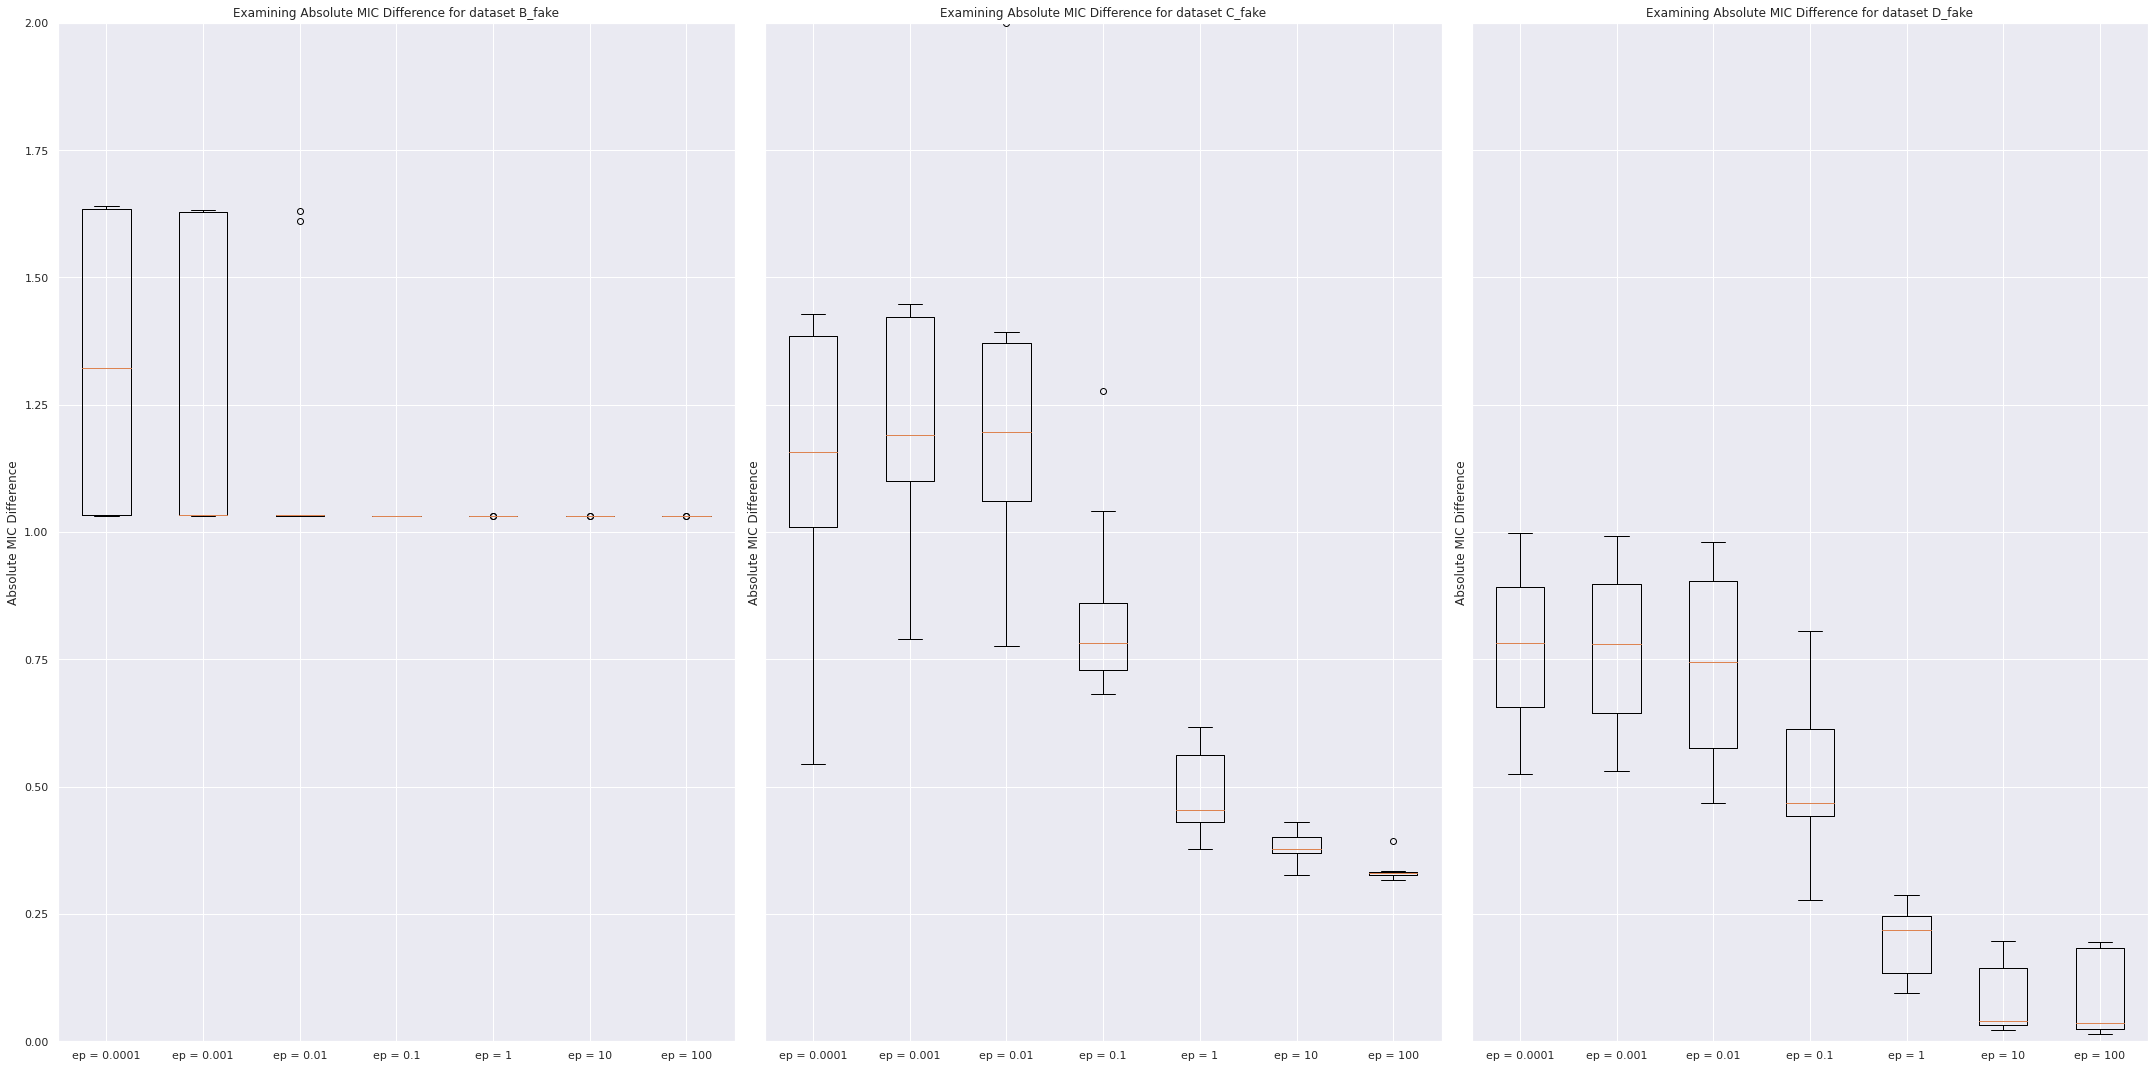

In [30]:
#plotting the MIC  difference for different synthetic data generating methods on fake data
fig, axs = plt.subplots(1,3, figsize=(30,15),sharey=True)
e = [ep for ep in results_4c_pt2[1]['B_fake'].keys()]

key_list = ['B_fake','C_fake','D_fake']

for i in range(3):
  k = key_list[i]
  d = results_4c_pt2[1][k]
  label_list = ['ep = ' + str(ep) for ep in e]
  ax = axs[i] 
  ax.boxplot([d[e[0]], d[e[1]], d[e[2]],d[e[3]], d[e[4]], d[e[5]], d[e[6]]],
             labels=label_list)
  ax.set_title('Examining Absolute MIC Difference for dataset ' + k)
  ax.set_ylabel('Absolute MIC Difference')
plt.tight_layout()
plt.ylim((0,2))

## Part (d)

Create and inspect differentially privаte spanning tree. There is no need to write your own code for this part, but what you write in the report should demonstrate a nuanced understanding of how the structures differ between the two approaches (DataSynthesizer and MST).

In [31]:
# Run and then ignore this cell, installing MST
!git clone https://github.com/ryan112358/private-pgm.git
%cd private-pgm
! pip install -r requirements.txt
! python setup.py install
import os, sys
sys.path.append(os.getcwd())
!git clone https://github.com/lurosenb/host_mst_wrapper
sys.path.insert(1, "/content/private-pgm/src")
from host_mst_wrapper.mst.mst import MSTSynthesizer
clear_output()

In [32]:
# Here we have to convert all the data from hw_compas to categorical numerical,
# so that MST can process it.
df_real['sex'] = df_real['sex'].astype('category')
df_real['race'] = df_real['race'].astype('category')
df_real['score'] = df_real['score'].astype('category')
categorical = df_real.select_dtypes(['category']).columns
df_real[categorical] = df_real[categorical].apply(lambda x: x.cat.codes)



synth = MSTSynthesizer(epsilon=0.1, domain_path="host_mst_wrapper/mst/compas-domain.json")
synth.fit(df_real)



Domain(sex: 2, age: 101, race: 6, score: 11)
Index(['sex', 'age', 'race', 'score'], dtype='object')
[('sex', 'score'), ('age', 'score'), ('race', 'score')]


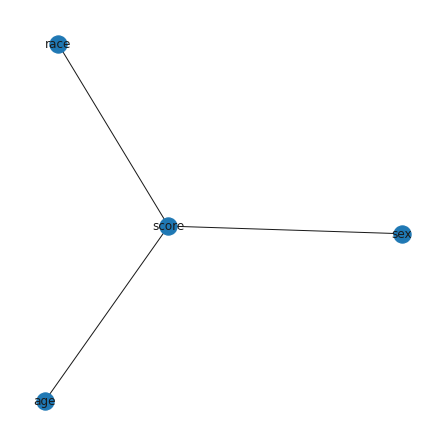

In [33]:
plt.figure(figsize=(6,6))
synth.display_MST_graph()

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
Constructed Bayesian network:
    age  has parents ['score'].
    race has parents ['age', 'score'].
    sex  has parents ['race', 'age'].


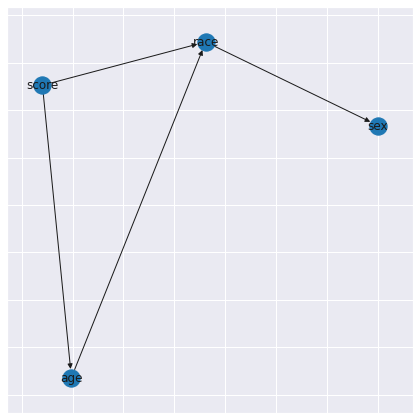

In [76]:
import networkx as nx

plt.figure(figsize=(6,6))
temp_D1 = generate_data_D(real_data_file, output_data_size, epsilon=.1, seed=27, verbose=True)

graph = nx.DiGraph()
graph.add_edges_from([('score','age'), ('score','race'), ('race','sex'), ('age','race'), ('race','sex')])
nx.draw_networkx(graph, arrows=True)
plt.tight_layout()


## Part (e)
### 1. KL Divergence for MST
Study how KL Divergence compares on hw_compas for MST compared to dataset **D** (df_real_D), as you vary __epsilon__ = [0.1, 0.2, ..., 1]. You only need to do this for **5 datasets** per epsilon this time (i.e., run 5 iterations per epsilon). Expect each MST run to take ~15-20 seconds.

You can fit the MST synthesizer using the same code as above for visualizing. Once fit, you can produce a synthetic dataset by simply using the following method:

`mst_fake_data = synth.sample(samples=10000)`

After running this command, `mst_fake_data` will be a pandas dataframe with 10000 rows and with the same columns as whatever dataframe MST was fit on! 

In [53]:
# You can use sns.boxplot for the plots
# For examples, refer to https://seaborn.pydata.org/generated/seaborn.boxplot.html
import numpy as np
def understand_variability4():
  """
  calculates KL-divergence for various levels of epsilon for MST algorithim on Compas data
  """
  #create results dict
  results_dict = {'MST':{.01:[],
                       .02:[],
                       .03:[],
                       .04:[], 
                       .05:[],
                       .06:[],
                       .07:[],
                       .08:[],
                       .09:[],
                       .1:[]
                      }
                  }
  
  df_real['sex'] = df_real['sex'].astype('category')
  df_real['race'] = df_real['race'].astype('category')
  df_real['score'] = df_real['score'].astype('category')
  categorical = df_real.select_dtypes(['category']).columns 
  df_real[categorical] = df_real[categorical].apply(lambda x: x.cat.codes)
  #keyboard smashing to generate random seeds after using three numbers i personally like  
  epsilon_list = [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]
  seed_list = [27,65,26, 23412, 34012]

  for i in range(len(epsilon_list)):
    for j in range(len(seed_list)):
      np.random.seed(seed_list[j])
      MSTSynthesizer(epsilon=epsilon_list[i], domain_path="host_mst_wrapper/mst/compas-domain.json")
      synth.fit(df_real)
      mst_data = synth.sample(samples=10000) 
      clear_output()
      results_dict['MST'][epsilon_list[i]].append(kl_test(df_real,mst_data, 'race'))
  return(results_dict)
    

In [54]:
results_dict5 = understand_variability4()

### 2. Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

In [133]:
epsilons_mst_mi = [0.001, 0.01, 0.1, 1, 10, 100]


def understand_variability5():
  """
  function that generates ten synthetic datasets COMPAS, calculates the min, mean, median, max of the age column and outputs them in a dictionary
  each key in that dictionary corresponds to the method used to synthetically generate the dataset
  the value of the key is a dictionary that has our four metrics of interest. The values of this dictionary are the recorded metrics
  """
  #create results dict
  results_dict1 = {'MST_compas':{.001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       },
                  'D_compas':{.001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }
                  }
  results_dict2 = {'MST_fake':{.001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       },
                  'D_fake':{.001:[],
                       .01:[], 
                       .1:[],
                       1:[],
                       10:[],
                       100:[]
                       }
                  }
  
  df_real['sex'] = df_real['sex'].astype('category')
  df_real['race'] = df_real['race'].astype('category')
  df_real['score'] = df_real['score'].astype('category')
  categorical = df_real.select_dtypes(['category']).columns 
  df_real[categorical] = df_real[categorical].apply(lambda x: x.cat.codes)

  #keyboard smashing to generate random seeds after using three numbers i personally like  
  epsilon_list = [.01,.1,1,10,100]
  seed_list = [2714,612,2126, 23412, 34012]

  for i in range(len(epsilon_list)):
    for j in range(len(seed_list)):
      #set seed for MST data generating process
      np.random.seed(seed_list[j])
      synth1 = MSTSynthesizer(epsilon=epsilon_list[i], domain_path="host_mst_wrapper/mst/compas-domain.json")
      synth1.fit(df_real) 
      mst_data_real = synth1.sample(samples=10000) 
      temp_D1 = generate_data_D(real_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)


      synth2 = MSTSynthesizer(epsilon=epsilon_list[i], domain_path="host_mst_wrapper/mst/fake-domain.json")
      synth2.fit(df_fake) 
      mst_data_fake = synth2.sample(samples=10000) 
      temp_D2 = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon_list[i], seed=seed_list[j], verbose=False)

      clear_output()
      df_list1 = [mst_data_real, temp_D1]
      df_list2 = [mst_data_fake, temp_D2]

      key_list1 = ['MST_compas','D_compas']
      key_list2 = ['MST_fake','D_fake']
      
      compas_mic = pairwise_attributes_mutual_information(df_real)
      fake_mic = pairwise_attributes_mutual_information(df_fake)
    #specifiying a key list to guarantee an order in below for loop when indexing 
      for v in range(len(key_list2)):
          pairwise_mic_1 = pairwise_attributes_mutual_information(df_list1[v])
          pairwise_mic_2 = pairwise_attributes_mutual_information(df_list2[v])

          delta_matrix1 = abs(pairwise_mic_1 - compas_mic)
          delta_matrix2 = abs(pairwise_mic_2-fake_mic)
          
          cumulative_mic_1 = lower_sum = np.tril(delta_matrix1).sum()-np.trace(delta_matrix1) #trace is all 0s, formula for lower diagonal
          cumulative_mic_2 = lower_sum = np.tril(delta_matrix2).sum()-np.trace(delta_matrix2) #trace is all 0s, formula for lower diagonal

          results_dict1[key_list1[v]][epsilon_list[i]].append(cumulative_mic_1)
          results_dict2[key_list2[v]][epsilon_list[i]].append(cumulative_mic_2)
  return([results_dict1,results_dict2])
    

In [134]:
results_dict6 = understand_variability5()

(0.0, 0.8)

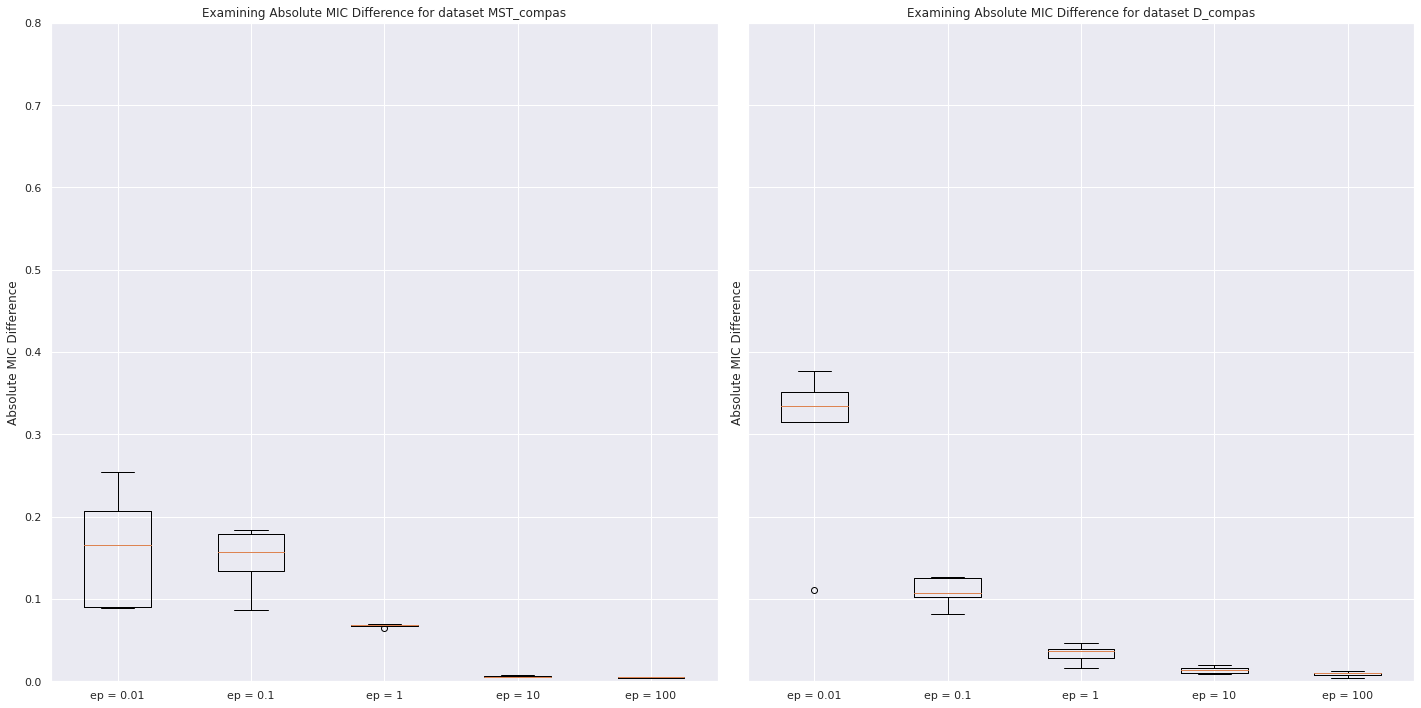

In [148]:
fig, axs = plt.subplots(1,2, figsize=(20,10),sharey=True)
e = [ep for ep in results_dict6[0]['D_compas'].keys()]

key_list = ['MST_compas','D_compas']

for i in range(2):
  k = key_list[i]
  d = results_dict6[0][k]
  label_list = ['ep = ' + str(ep) for ep in e][1:]
  ax = axs[i] 
  ax.boxplot([d[e[1]], d[e[2]],d[e[3]], d[e[4]], d[e[5]]],
             labels=label_list)
  ax.set_title('Examining Absolute MIC Difference for dataset ' + k)
  ax.set_ylabel('Absolute MIC Difference')
plt.tight_layout()
plt.ylim((0,.8))

(0.0, 1.5)

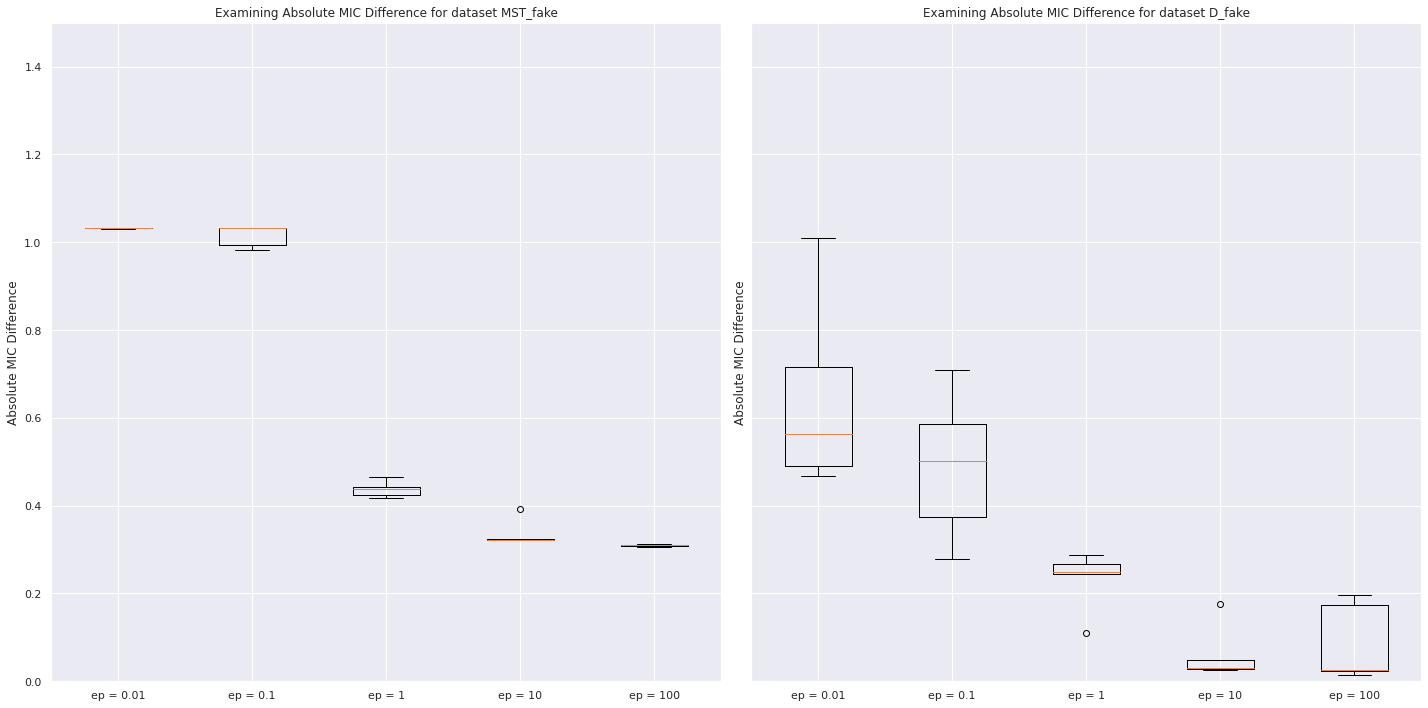

In [149]:
bfig, axs = plt.subplots(1,2, figsize=(20,10),sharey=True)
e = [ep for ep in results_dict6[1]['MST_fake'].keys()]

key_list = ['MST_fake','D_fake']

for i in range(2):
  k = key_list[i]
  d = results_dict6[1][k]
  label_list = ['ep = ' + str(ep) for ep in e][1:]
  ax = axs[i] 
  ax.boxplot([d[e[1]], d[e[2]],d[e[3]], d[e[4]], d[e[5]]],
             labels=label_list)
  ax.set_title('Examining Absolute MIC Difference for dataset ' + k)
  ax.set_ylabel('Absolute MIC Difference')
plt.tight_layout()
plt.ylim((0,1.5))

In [153]:
#understand why at high epsilon MST underperforms Correlated attribute mode:

synth2 = MSTSynthesizer(epsilon=100, domain_path="host_mst_wrapper/mst/fake-domain.json")
synth2.fit(df_fake) 



Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_1'), ('parent_2', 'child_2'), ('child_1', 'child_2')]


In [151]:
temp_D2 = generate_data_D(fake_data_file, output_data_size, epsilon=100, seed=27, verbose=True)

================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute child_1
Adding attribute parent_1
Adding attribute parent_2
========================== BN constructed ==========================
Constructed Bayesian network:
    child_1  has parents ['child_2'].
    parent_1 has parents ['child_1', 'child_2'].
    parent_2 has parents ['parent_1', 'child_2'].


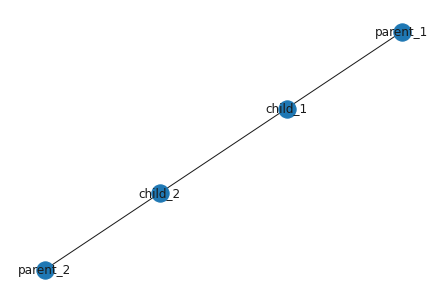

In [154]:
synth2.display_MST_graph()
mst_data_fake = synth2.sample(samples=10000) 

Domain(parent_1: 3, parent_2: 3, child_1: 3, child_2: 3)
Index(['parent_1', 'parent_2', 'child_1', 'child_2'], dtype='object')
[('parent_1', 'child_2'), ('parent_2', 'child_2'), ('child_1', 'child_2')]
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute parent_2
Adding attribute child_1
Adding attribute parent_1
========================== BN constructed ==========================
Constructed Bayesian network:
    parent_2 has parents ['child_2'].
    child_1  has parents ['parent_2', 'child_2'].
    parent_1 has parents ['child_1', 'parent_2'].


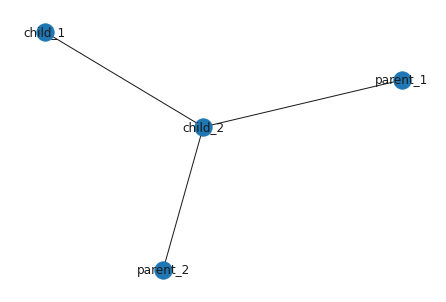

In [155]:
synth2 = MSTSynthesizer(epsilon=.1, domain_path="host_mst_wrapper/mst/fake-domain.json")
synth2.fit(df_fake) 
synth2.display_MST_graph()
mst_data_fake = synth2.sample(samples=10000) 

temp_D2 = generate_data_D(fake_data_file, output_data_size, epsilon=.1, seed=27, verbose=True)